In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [10]:
# 1. 데이터 확보
import zipfile
filepath = 'data/glaucoma.zip'
with zipfile.ZipFile(filepath, 'r') as f:
    f.extractall('data/')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
                    rotation_range=20, # 최대 회전 각도
                    width_shift_range=0.2, # 가로 방향 -20%~20% 이동 정도
                    height_shift_range=0.2, # 상하 방향 이동 정도
                    horizontal_flip=True, # 수평 뒤집기
                    vertical_flip=True) # 수직 뒤집기
train_data = train_generator.flow_from_directory(
        'data/glaucoma/train',
        target_size=(224,224),
        batch_size=4,
        class_mode='sparse' # 종속변수에 원핫인코딩 안 함
)
test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(
    'data/glaucoma/test',
    target_size=(224,224),
    batch_size=4,
    class_mode='sparse'
)

Found 828 images belonging to 3 classes.
Found 320 images belonging to 3 classes.


In [4]:
# 학습데이터와 테스트 데이터가 될 이미지의 채널 확인
from tensorflow.keras.preprocessing import image # 이미지를 읽어오기
img = image.load_img('data/glaucoma/test/normal_control/1.png')
img_data = image.img_to_array(img)
img_data.shape

(240, 240, 3)

In [5]:
# 2. 모델 구성
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np
from tensorflow.keras.models import Sequential # ResNet50의 Dense 층을 사용자 추가
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image # 이미지를 읽어오기

resnet_model = ResNet50(input_shape=(224,224,3), 
                        include_top=False) # 컨볼루션과 폴링 레이어만 구조와 가중치를 가져옴
resnet_model.trainable = True # RestNet의 가중치도 업데이트 가능
# model = Sequential()
# model.add(resnet_model)
# model.add(Flatten())
# model.add(Dense(units=1024, activation='relu'))
# model.add(Dense(units=3, activation='softmax'))
model = Sequential([
    resnet_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()
# 학습 시 필요한 용량
 # 1. 파라미터 사용 메모리 사용량 : 파라미터수(126,352,259)*4byte / 1024의 제곱 = 482MB
 # 2. 배치사이즈=3일 경우 3* (224*224*3) * 4byte / 1024의 제곱 = 19MB
 # 각 layer층 마다 활성화 값

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 30,010,499
Trainable params: 29,957,379
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
# 3. 학습 설정
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 학습 시키기
model.fit(train_data, validation_data=test_data,
         epochs=20, batch_size=3)

Epoch 1/20
207/207 [==============================] - 33s 128ms/step - loss: 2.9395 - accuracy: 0.4070 - val_loss: 11.6601 - val_accuracy: 0.2719
Epoch 2/20
207/207 [==============================] - 25s 123ms/step - loss: 0.8809 - accuracy: 0.6014 - val_loss: 1.6353 - val_accuracy: 0.6812
Epoch 3/20
207/207 [==============================] - 25s 123ms/step - loss: 0.6637 - accuracy: 0.7017 - val_loss: 7.0896 - val_accuracy: 0.3406
Epoch 4/20
207/207 [==============================] - 26s 123ms/step - loss: 0.6949 - accuracy: 0.7053 - val_loss: 5.7797 - val_accuracy: 0.6625
Epoch 5/20
207/207 [==============================] - 26s 123ms/step - loss: 0.6520 - accuracy: 0.6981 - val_loss: 1.0038 - val_accuracy: 0.6938
Epoch 6/20
207/207 [==============================] - 26s 124ms/step - loss: 0.5622 - accuracy: 0.7415 - val_loss: 2.2093 - val_accuracy: 0.6844
Epoch 7/20
207/207 [==============================] - 27s 128ms/step - loss: 0.5611 - accuracy: 0.7572 - val_loss: 1.1655 - val_a

In [9]:
# 평가하기
model.evaluate(test_data)

80/80 [==============================] - 3s 33ms/step - loss: 52.8118 - accuracy: 0.6719


[52.81177520751953, 0.671875]

1/1 [==============================] - 1s 1s/step
[[1.0000000e+00 2.2561232e-38 0.0000000e+00]]
0


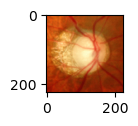

In [7]:
# 예측하기 (keras.preprocessing.image 이용)
img = image.load_img('data/test.png', target_size=(224,224)) # Image 객체로 가져옴
x = image.img_to_array(img) # (224,224,3)
x = x.reshape(-1, 224, 224, 3)
pred = model.predict(x)
print(pred)

print(pred.argmax())
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 31ms/step
[[1.0000000e+00 2.2561232e-38 0.0000000e+00]]
0


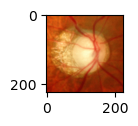

In [8]:
# 예측하기 (openCV 이용)
import cv2
img = cv2.imread('data/test.png', cv2.IMREAD_ANYCOLOR) # BGR포맷 넘파이
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 240*240*3
img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA) # 224*224*3

x = x.reshape(-1, 224, 224, 3)
pred = model.predict(x)
print(pred)

print(pred.argmax())
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.show()